In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from astropy.time import Time
from astropy.table import Table
from style import output_folder, big_fontsize, base_width, base_height, dpi
import seaborn as sns
import json
from astropy.time import Time

In [31]:
base_file = "data/neutrino_too_followup.xlsx"

obs = pd.read_excel(base_file, sheet_name="OVERVIEW_FU", skiprows=[0, 1, 2])

obs = obs[~np.isnan(obs["RA"])]

non = pd.read_excel(base_file, sheet_name="OVERVIEW_NOT_FU", skiprows=[0, 1], usecols=range(11))

   Event Class  RA RA Unc (rectangle)  Dec Dec Unc (rectangle)  \
24   NaN   NaN NaN                NaN  NaN                 NaN   
25   ALL   NaN NaN                NaN  NaN                 NaN   

    Area (rectangle)  Observed area (from Healpix)  \
24               NaN                           NaN   
25        178.219147                    176.680856   

    Observed area (corrected for chip gaps)  Signalness  \
24                                      NaN         NaN   
25                               154.327812    11.20375   

    Energy estimate [TeV]  Separation from gal. plane IC GCN ZTF ATEL/GCN  \
24                    NaN                         NaN    NaN          NaN   
25                    NaN                         NaN    NaN          NaN   

   Additional ZTF GCN Additional ZTF GCN.1  
24                NaN                  NaN  
25                NaN                  NaN  
2


In [3]:
relabels = {
    "Alert retraction": "Alert Retraction",
    "Proximity to sun": "Proximity to Sun",
    "Separation from galactic plane": "Separation from Galactic Plane",
    "Poor Signalness and Localization": "Poor Signalness and Localisation"
}

for key, new in relabels.items():
    mask = non["Rejection reason"] == key
    non["Rejection reason"][mask] = new


Alert retraction Alert Retraction
Proximity to sun Proximity to Sun
Separation from galactic plane Separation from Galactic Plane
Poor Signalness and Localization Poor Signalness and Localisation


/var/folders/hd/1411jr114w9cvmmnw9mx0xvr0000gn/T/ipykernel_65876/1941142432.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non["Rejection reason"][mask] = new


# Alert Statistics

['Observed', 'Alert Retraction', 'Low Altitude', 'Poor Signalness \n and Localisation', 'Proximity to Sun', 'Separation from \n Galactic Plane', 'Southern Sky', 'Telescope Maintenance']


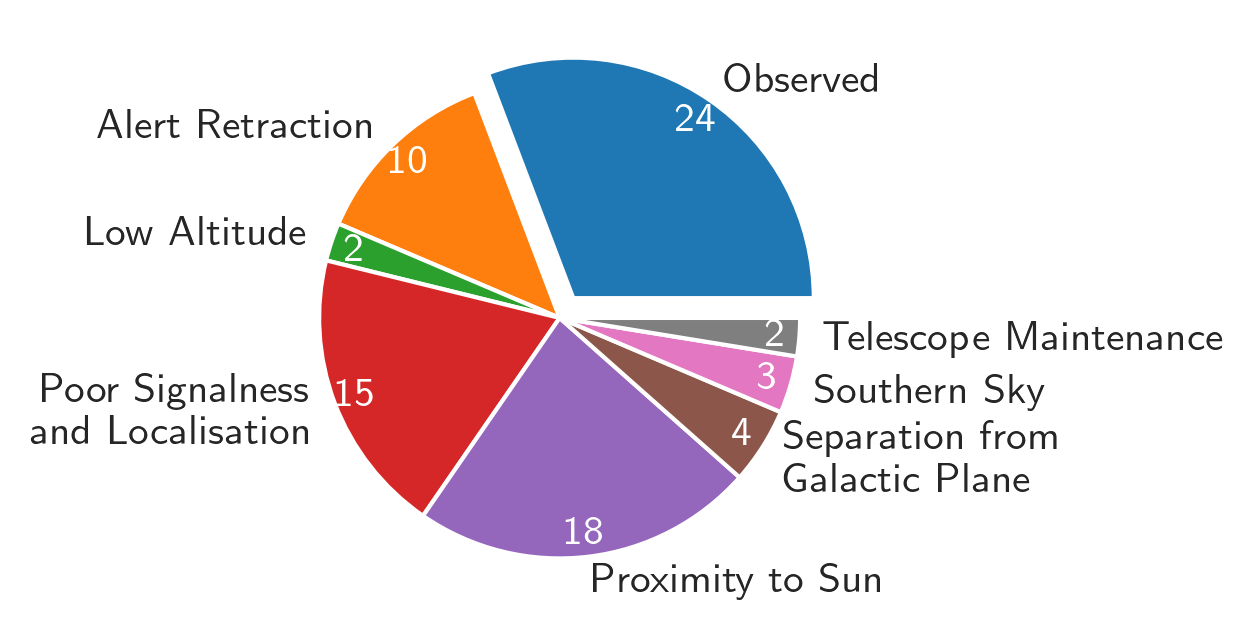

In [28]:
plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax1 = plt.subplot(111)

reasons = [x if x != "Poor Signalness and Localisation" else "Poor Signalness \n and Localisation" for x in non["Rejection reason"]]
reasons = [x if x != "Separation from Galactic Plane" else "Separation from \n Galactic Plane" for x in reasons]

t_min = 1803
t_max = 2303

reasons = [x for i, x in enumerate(reasons) if np.logical_and(float(non["Event"][i][2:6]) > t_min, float(non["Event"][i][2:6]) < t_max)]
labels = sorted(list(set(reasons)))

sizes = []

for l in labels:
    sizes.append(list(reasons).count(l))
    
explode =[0.1] + [0.0 for _ in labels]

labels = ["Observed"] + labels
sizes = [len(obs)] + sizes

def absolute_value(val):
    a  = np.round(val/100.*np.sum(sizes), 0)
    return int(a)

print(labels)

patches, texts, autotexts = ax1.pie(sizes, 
                                    explode=explode, 
                                    labels=labels, 
                                    autopct=absolute_value,
                                    pctdistance=0.9,
                                    textprops={'fontsize': big_fontsize}
                                   )

[autotext.set_color('white') for autotext in autotexts]


ax1.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

filename = "pie.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)


# Observed alerts (Table 1)

In [5]:
text = r"""
\begin{table*}
\centering
    \begin{tabular}{||c | c c c c c c ||} 
         \hline
         \textbf{Event} & \textbf{R.A. (J2000)} & \textbf{Dec (J2000)} & \textbf{90\% area} & \textbf{ZTF obs} &~ \textbf{Signalness}& \textbf{Refs}\\
         & \textbf{[deg]}&\textbf{[deg]}& \textbf{[sq. deg.]}& \textbf{[sq. deg.]} &&\\
         \hline
"""

tot_area = 0.

for index, row in obs.iterrows():
    
    name = str(row["Event"].lower())
        
    ras = json.loads(row["RA Unc (rectangle)"])
    
    decs = json.loads(row["Dec Unc (rectangle)"])    
    
    delta_r = ras[0] - ras[1]
    delta_d = decs[0] - decs[1]
    
    area = delta_r * delta_d  * np.cos(np.radians(float(row["Dec"])))
    
    if np.isnan(float(row["Signalness"])):
        s = "-"
    else:
        s = f'{100.*row["Signalness"]:.0f}\%'
                    
    text += f'\t {row["Event"]} & {row["RA"]} & {row["Dec"]:+.2f} & {area:.1f} & {row["Observed area (corrected for chip gaps)"]:.1f} & {s} & \cite{{{name}}} \\\\\ \n'

    text += f'\t &&&&&& \cite{{{name}_ztf}} \\\\ \n'
    if not isinstance(row["Additional ZTF GCN"], float):
        text += f'\t &&&&&& \cite{{{name}_ztf_2}} \\\\ \n'
    
    text += "\t \hline"
    
    tot_area += row["Observed area (corrected for chip gaps)"]

text += f"""
    \end{{tabular}}
    \caption{{Summary of the {len(obs)} neutrino alerts followed up by ZTF since survey start on 2018 March 20.}}
    \label{{tab:nu_alerts}}
\end{{table*}}
"""

print(text)


\begin{table*}
\centering
    \begin{tabular}{||c | c c c c c c ||} 
         \hline
         \textbf{Event} & \textbf{R.A. (J2000)} & \textbf{Dec (J2000)} & \textbf{90\% area} & \textbf{ZTF obs} &~ \textbf{Signalness}& \textbf{Refs}\\
         & \textbf{[deg]}&\textbf{[deg]}& \textbf{[sq. deg.]}& \textbf{[sq. deg.]} &&\\
         \hline
	 IC190503A & 120.28 & +6.35 & 1.9 & 1.4 & 36\% & \cite{ic190503a} \\\ 
	 &&&&&& \cite{ic190503a_ztf} \\ 
	 \hline	 IC190619A & 343.26 & +10.73 & 27.2 & 21.6 & 55\% & \cite{ic190619a} \\\ 
	 &&&&&& \cite{ic190619a_ztf} \\ 
	 \hline	 IC190730A & 225.79 & +10.47 & 5.4 & 4.5 & 67\% & \cite{ic190730a} \\\ 
	 &&&&&& \cite{ic190730a_ztf} \\ 
	 \hline	 IC190922B & 5.76 & -1.57 & 4.5 & 4.1 & 51\% & \cite{ic190922b} \\\ 
	 &&&&&& \cite{ic190922b_ztf} \\ 
	 \hline	 IC191001A & 314.08 & +12.94 & 25.5 & 23.1 & 59\% & \cite{ic191001a} \\\ 
	 &&&&&& \cite{ic191001a_ztf} \\ 
	 \hline	 IC200107A & 148.18 & +35.46 & 7.6 & 6.3 & - & \cite{ic200107a} \\\ 
	 &&&&&& \cite

# Not observed

In [6]:
reasons = ["Alert Retraction", "Proximity to Sun", "Low Altitude", "Southern Sky", "Separation from Galactic Plane", "Poor Signalness and Localisation", "Telescope Maintenance"]
seps = [1, 0, 0, 0, 1, 1, 1]

full_mask = np.array([float(x[2:6]) > 1803 for x in non["Event"]])


text = r"""
\begin{table*}
    \centering
    \begin{tabular}{||c c ||} 
        \hline
        \textbf{Cause} & \textbf{Events} \\
        \hline
"""

for i, reason in enumerate(reasons):
    mask = non["Rejection reason"] == reason
    
    names = list(non["Event"][full_mask][mask])
    
    for j, name in enumerate(names):
        names[j] = f'{name} \citep{{{name.lower()}}}'
    
    text += f'\t {reason} & '
    
    n_int = 2
                 
    while len(names) > n_int:
        text += f'{", ".join(names[:n_int])} \\\\ \n \t & '
        names = names[n_int:]
        
    text += f'{", ".join(names)} \\\\ \n'

#     if seps[i]:
    if True:
        text += "\t \hline \n"
        
text +=f"""
    \end{{tabular}}
    \caption{{Summary of the {np.sum(full_mask)} neutrino alerts that were not followed up by ZTF since survey start on 2018 March 20.}}
    \label{{tab:nu_non_observed}}
\end{{table*}}
"""

print(text)


\begin{table*}
    \centering
    \begin{tabular}{||c c ||} 
        \hline
        \textbf{Cause} & \textbf{Events} \\
        \hline
	 Alert Retraction & IC180423A \citep{ic180423a}, IC181031A \citep{ic181031a} \\ 
 	 & IC190205A \citep{ic190205a}, IC190529A \citep{ic190529a} \\ 
 	 & IC200120A \citep{ic200120a}, IC200728A \citep{ic200728a} \\ 
 	 & IC201115B \citep{ic201115b}, IC210213A \citep{ic210213a} \\ 
 	 & IC210322A \citep{ic210322a}, IC210519A \citep{ic210519a} \\ 
	 \hline 
	 Proximity to Sun & IC180908A \citep{ic180908a}, IC181014A \citep{ic181014a} \\ 
 	 & IC190124A \citep{ic190124a}, IC190704A \citep{ic190704a} \\ 
 	 & IC190712A \citep{ic190712a}, IC190819A \citep{ic190819a} \\ 
 	 & IC191119A \citep{ic191119a}, IC200227A \citep{ic200227a} \\ 
 	 & IC200421A \citep{ic200421a}, IC200615A \citep{ic200615a} \\ 
 	 & IC200806A \citep{ic200806a}, IC200921A \citep{ic200921a} \\ 
 	 & IC200926B \citep{ic200926b}, IC201014A \citep{ic201014a} \\ 
 	 & IC201115A \citep{ic201115

# Appendix table

In [7]:
joint = pd.concat([non, obs], axis=0).sort_values(by=['Event'])

text = fr"""
\begin{{longtable}}[c]{{||c c c c c c ||}}
\caption{{Summary of all {len(joint)} neutrino alerts issued since under the IceCube Realtime Program. Directions are not indicated for retracted events.}} \label{{tab:all_nu_alerts}} \\
 \hline
 \textbf{{Event}} & \textbf{{R.A. (J2000)}} & \textbf{{Dec (J2000)}} & \textbf{{90\% area}} &~ \textbf{{Signalness}}& \textbf{{Ref}}\\
 & \textbf{{[deg]}}&\textbf{{[deg]}} & \textbf{{[sq. deg.]}} &&\\
 \hline
\endfirsthead
 \hline
\textbf{{Event}} & \textbf{{R.A. (J2000)}} & \textbf{{Dec (J2000)}} & \textbf{{90\% area}} &~ \textbf{{Signalness}}& \textbf{{Ref}}\\
 & \textbf{{[deg]}}&\textbf{{[deg]}} & \textbf{{[sq. deg.]}} &&\\
 \hline
\endhead
\hline
\endfoot
\hline
\endlastfoot
\hline%
"""

for index, row in joint.iterrows():
    
    name = str(row["Event"].lower())
    
    if not isinstance(row["RA Unc (rectangle)"], float):
        
        ras = json.loads(str(row["RA Unc (rectangle)"]))

        decs = json.loads(row["Dec Unc (rectangle)"])    

        delta_r = ras[0] - ras[1]
        delta_d = decs[0] - decs[1]

        area = f'{delta_r * delta_d  * np.cos(np.radians(float(row["Dec"]))):.1f}'

    else:
        area = "-"

    if np.isnan(float(row["Signalness"])):
        s = "-"
    else:
        s = f'{100.*row["Signalness"]:.0f}\%'

    if np.isnan(float(row["Dec"])):
        r = "-"
        d = "-"
    else:
        r = f'{row["RA"]}'
        d = f'{row["Dec"]:+.2f}'
        
    if name not in ["ic160731a", "ic160814a", "ic170312a"]:
        c = name
    else:
        c  = "ic_txs_mm_18"

    text += f'\t {row["Event"]} & {r} & {d} & {area} & {s} & \cite{{{c}}} \\\\ \n'
    
text += f"""
\end{{longtable}}

"""

print(text)



\begin{longtable}[c]{||c c c c c c ||}
\caption{Summary of all 91 neutrino alerts issued since under the IceCube Realtime Program. Directions are not indicated for retracted events.} \label{tab:all_nu_alerts} \\
 \hline
 \textbf{Event} & \textbf{R.A. (J2000)} & \textbf{Dec (J2000)} & \textbf{90\% area} &~ \textbf{Signalness}& \textbf{Ref}\\
 & \textbf{[deg]}&\textbf{[deg]} & \textbf{[sq. deg.]} &&\\
 \hline
\endfirsthead
 \hline
\textbf{Event} & \textbf{R.A. (J2000)} & \textbf{Dec (J2000)} & \textbf{90\% area} &~ \textbf{Signalness}& \textbf{Ref}\\
 & \textbf{[deg]}&\textbf{[deg]} & \textbf{[sq. deg.]} &&\\
 \hline
\endhead
\hline
\endfoot
\hline
\endlastfoot
\hline%
	 IC160427A & 240.57 & +9.34 & 1.4 & - & \cite{ic160427a} \\ 
	 IC160731A & 214.5 & -0.33 & 2.2 & 85\% & \cite{ic_txs_mm_18} \\ 
	 IC160806A & 122.81 & -0.81 & 0.0 & 28\% & \cite{ic160806a} \\ 
	 IC160814A & 200.3 & -32.40 & 12.0 & - & \cite{ic_txs_mm_18} \\ 
	 IC161103A & 40.83 & +12.56 & 3.1 & - & \cite{ic161103a} \\ 
	

In [8]:
for index, row in obs.iterrows():
    name = row["Event"]
    candidates = pd.read_excel(base_file, sheet_name=name, skiprows=range(6), header=0)
    if len(candidates) > 2:
        
        text = r"""
        \begin{table*}
        \centering
            \begin{tabular}{||c | c c c ||} 
                 \hline
                 \textbf{ZTF Name} & \textbf{IAU Name} & \textbf{Classification} & \textbf{Peak Apparent Magnitude} \\
                 \hline
        """
        
        for _, crow in candidates.iterrows():
            
            text += f"\t {crow['Name']} & {crow['IAU Name']} & {crow['Classification']} & {crow['max brightness']} \\\\ \n"
        
        
        text +=f"""
            \end{{tabular}}
            \caption{{Candidates for {name}.}}
            \label{{tab:{str(name.lower())}}}
        \end{{table*}}
        """
        
        print(text)
    
    


        \begin{table*}
        \centering
            \begin{tabular}{||c | c c c ||} 
                 \hline
                 \textbf{ZTF Name} & \textbf{IAU Name} & \textbf{Classification} & \textbf{Peak Apparent Magnitude} \\
                 \hline
        	 ZTF18abolwbb & nan & AGN Variability & 19.4 (r) \\ 
	 ZTF18abueqkl & AT2020kqj & AGN Variability & 19.3 (g) \\ 
	 ZTF18acehkni & nan & AGN Variability & 19.4 (r) \\ 
	 ZTF18actxchc & nan & AGN Variability & 18.0 (g) \\ 
	 ZTF19aadaszg & SN2019rg & SN Ia & 15.9 (r) \\ 
	 ZTF19aawnawu & nan & AGN Variability? & 20.0 (g) \\ 
	 ZTF19aaycone & nan & AGN Variability & 17.9 (g) \\ 
	 ZTF19aaycool & nan & AGN Variability & 20.3 (g) \\ 
	 ZTF19aaycosc & nan & AGN Variability & 19.3 (r) \\ 
	 ZTF19aaycoxd & nan & AGN Variability & 20.3 (g) \\ 
	 ZTF19abahiwr & AT2019izf & Unclassified & 19.5 (r) \\ 
	 ZTF19abahiya & nan & Unclassified & 19.6 (r) \\ 
	 ZTF19abahizn & nan & AGN Variability? & 19.7 (g) \\ 
	 ZTF19abahjcp & nan & AGN Varia


        \begin{table*}
        \centering
            \begin{tabular}{||c | c c c ||} 
                 \hline
                 \textbf{ZTF Name} & \textbf{IAU Name} & \textbf{Classification} & \textbf{Peak Apparent Magnitude} \\
                 \hline
        	 ZTF18acccxxf & AT2020tnn & nan & 19.7 (g) \\ 
	 ZTF18adbbnry & AT2020tnn & AGN? & 19.8 (g) \\ 
	 ZTF20acaapwk & SN2020tno & SN Ia & 18.9 (r) \\ 
	 ZTF20acaapwn & nan & Unclassified & 21.0 (g) \\ 
	 ZTF20acaapwo & AT2020tnp & Unclassified & 20.4 (r) \\ 
	 ZTF20acayuno & nan & AGN Variability & 21.1 (r) \\ 

            \end{tabular}
            \caption{Candidates for IC200916A.}
            \label{tab:ic200916a}
        \end{table*}
        

        \begin{table*}
        \centering
            \begin{tabular}{||c | c c c ||} 
                 \hline
                 \textbf{ZTF Name} & \textbf{IAU Name} & \textbf{Classification} & \textbf{Peak Apparent Magnitude} \\
                 \hline
        	 ZTF18abmkdiy & AT2019cvb

In [9]:
classifications = []

candidates = None

maxb = []
maxr = []
tranclass = []

for index, row in obs.iterrows():
    name = row["Event"]
    
    new = pd.read_excel(base_file, sheet_name=name, skiprows=range(6), header=0)
    if len(new) > 2:
        
        if candidates is None:
            candidates = new
        else:
            candidates = candidates.append(new, ignore_index=True)
        
        for _, crow in new.iterrows():
            
            maxb.append(float(crow['max brightness'].split(" ")[0]))
            
            if isinstance(crow['max range'], str):
                r = float(crow['max range'].split(" ")[0])
            else:
                r = 0.0
                
            maxr.append(r)
            
            if crow['Classification'] in ['AGN\n', 'AGN?', 'AGN']:
                classifications.append("AGN Flare")
            elif crow['Classification'] in ['AGN Variability', 'AGN Variability?']:
                classifications.append("AGN Variability")
#                 if r < 2.0:
#                     classifications.append("AGN Variability")
#                 else:
#                     classifications.append("AGN Flare")
                                
            elif str(crow['Classification']) in ["CV", "Star?", "CV???", "Star"]:
                classifications.append("Star")
            
            elif crow['Classification'] in ["???", np.nan, "?", "???\n\n"]:
                classifications.append("Unclassified")
#             elif "?" in crow['Classification']:
#                 classifications.append("Unclassified")
                
            elif crow['Classification'] in ["artifact?", "Artifact\n"]:
                classifications.append("Artifact")

            elif "Ia" in crow['Classification']:
                classifications.append("Transient")
                tranclass.append("SN Ia")
            elif "SN" in crow['Classification']:
                classifications.append("Transient")
                tranclass.append(crow['Classification'])
            elif crow['Classification'] in ["II/IIb"]:
                classifications.append("Transient")
                tranclass.append("SN II/IIb")
            
            elif crow['Classification'] in ["TDE", "Dwarf Nova"]:
                classifications.append("Transient")
                tranclass.append(crow['Classification'])
            else:
                classifications.append(crow['Classification'])
                
print(len(maxr), len(maxb))
                
candidates["max_brightness"] = maxb
candidates["max_range"] = maxr
candidates["class"] = classifications

162 162


['Artifact', 'Star', 'AGN Variability', 'AGN Flare', 'Transient', 'Unclassified']
In total there are 162 candidates from 24 neutrinos convering 154.33 sq. deg. This is a density of 1.05 candidates per sq. deg. of sky.
After removing ['Artifact', 'Star', 'AGN Variability'], we are left with 66 candidates, a reduction of 59.3%. This leaves  0.43 good candidates per sq. deg. of sky.


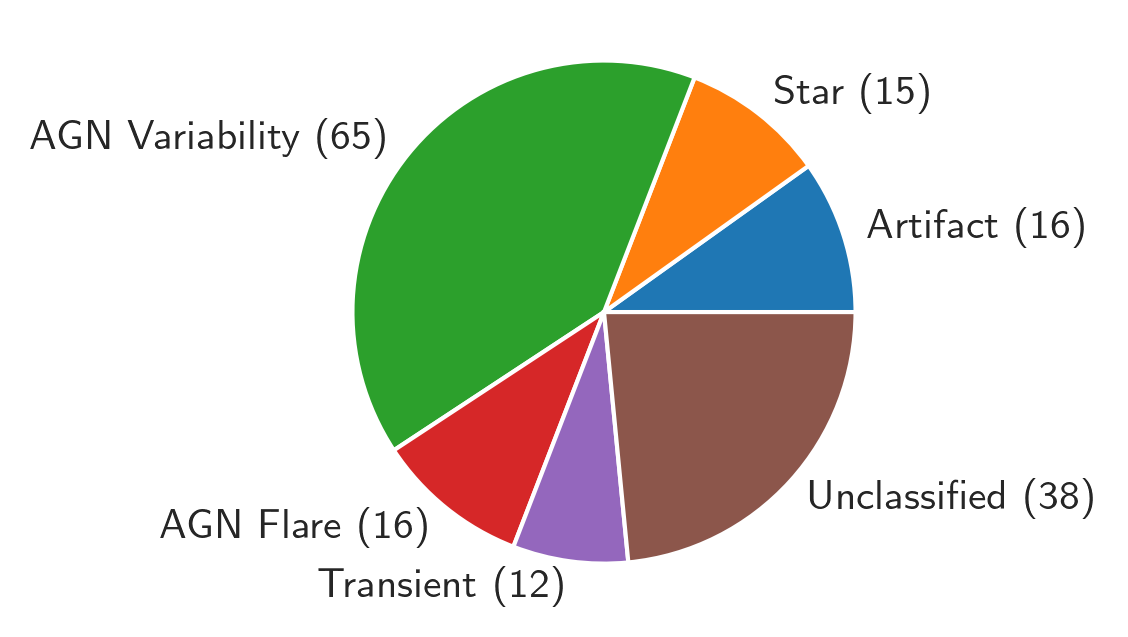

In [10]:
plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax1 = plt.subplot(111)

labels = []
sizes = []

e = 0.00

labels = ["Artifact", "Star", "AGN Variability", "AGN Flare", "Transient", "Unclassified", ]
explode = [0, 0, 0, e, e, e]

for x in list(set(classifications)):
    if x not in labels:
        labels.append(x)
        explode.append(0)
        
print(labels)

for i, l in enumerate(labels):
    s = list(classifications).count(l)
    sizes.append(s)
    labels[i] = f"{l} ({s})"
    
def absolute_value(val):
    a  = np.round(val/100.*np.sum(sizes), 0)
    return int(a)

boring = ["Artifact", "Star", "AGN Variability"]

interesting_mask = [x not in boring for x in classifications]

print(f"In total there are {len(classifications)} candidates from {len(obs)} neutrinos convering {tot_area:.2f} sq. deg. " 
      f"This is a density of {float(len(classifications))/tot_area:.2f} candidates per sq. deg. of sky.")


print(f"After removing {boring}, we are left with {np.sum(interesting_mask)} candidates, "
      f"a reduction of {100. * (1. - np.sum(interesting_mask)/float(len(classifications))):.1f}%. "
      f"This leaves  {np.sum(interesting_mask)/tot_area:.2f} good candidates per sq. deg. of sky."
     )

patches, texts = ax1.pie(sizes, 
                         labels=labels, 
                         explode=explode,
                         textprops={'fontsize': big_fontsize}
                        )

[autotext.set_color('white') for autotext in autotexts]

ax1.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

filename = "candidates.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

['SN Ia', 'SN II', 'SN Ic', 'Dwarf Nova', 'SN IIP', 'TDE', 'SN II/IIb']


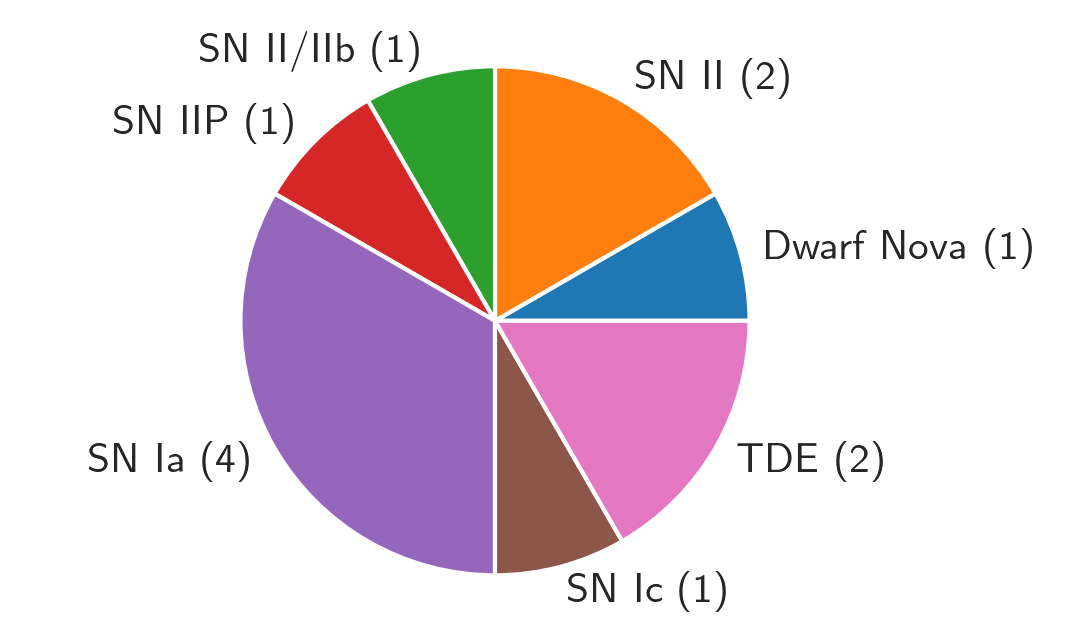

In [11]:
plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax1 = plt.subplot(111)

labels = []
sizes = []

e = 0.00

for x in list(set(tranclass)):
    if x not in labels:
        labels.append(x)
        
print(labels)

for i, l in enumerate(sorted(labels)):
    s = list(tranclass).count(l)
    sizes.append(s)
    labels[i] = f"{l} ({s})"
    
def absolute_value(val):
    a  = np.round(val/100.*np.sum(sizes), 0)
    return int(a)

patches, texts = ax1.pie(sizes, 
                         labels=labels, 
                         textprops={'fontsize': big_fontsize}
                        )

[autotext.set_color('white') for autotext in autotexts]

ax1.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

filename = "transient_pie.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

/var/folders/hd/1411jr114w9cvmmnw9mx0xvr0000gn/T/ipykernel_65876/1486288964.py:22: RuntimeWarning: invalid value encountered in true_divide
  fs = (n[1] - n[0])/(n[1])


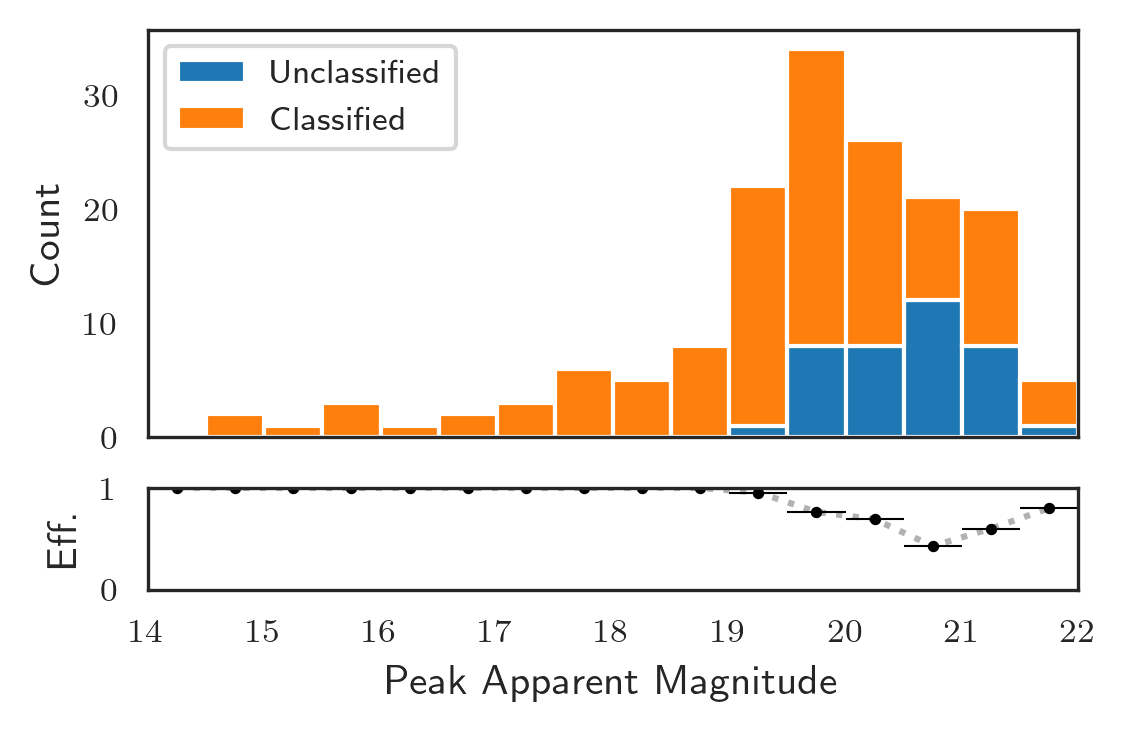

In [12]:
mask = np.array([x in ["Unclassified", "Unknown"] for x in candidates["class"]])

bins = np.linspace(14, 22, 17)
mids = 0.5*(bins[:-1] + bins[1:])

plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax1 = plt.subplot2grid((4, 1), (0, 0), colspan=3, rowspan=3)

n, _, _ = plt.hist(
    [candidates[mask]["max_brightness"], candidates[~mask]["max_brightness"]],
    label=["Unclassified", "Classified"],
    bins=bins,
    stacked=True
)

ax1.set_ylabel("Count")

plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), colspan=3, rowspan=1, sharex=ax1)

fs = (n[1] - n[0])/(n[1])
fs[np.isnan(fs)] = 1.

ax2.scatter(mids, fs, color="k", s=3.)
ax2.errorbar(mids, fs, color="k", linestyle=" ", xerr=0.25, elinewidth=0.5)
ax2.plot(mids, fs, alpha=0.3, color="k", linestyle=":")
ax2.set_ylim(0.0, 1.0)
ax2.set_ylabel("Eff.")

xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlim(bins[0], bins[-1])
plt.subplots_adjust(hspace=0.5)

ax2.set_xlabel("Peak Apparent Magnitude", fontsize=big_fontsize)

filename = "completeness.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

In [13]:
cb = 19.5
mask = mids > cb
ncut = (n.T[mask]).T

av_eff = np.sum(ncut[1]-ncut[0])/np.sum(ncut[1])
print(f"There are {int(np.sum(ncut[1]))} candidates fainter than {cb}, " 
      f"yielding an average classification efficiency of {100.*av_eff:.1f} %")

There are 106 candidates fainter than 19.5, yielding an average classification efficiency of 65.1 %


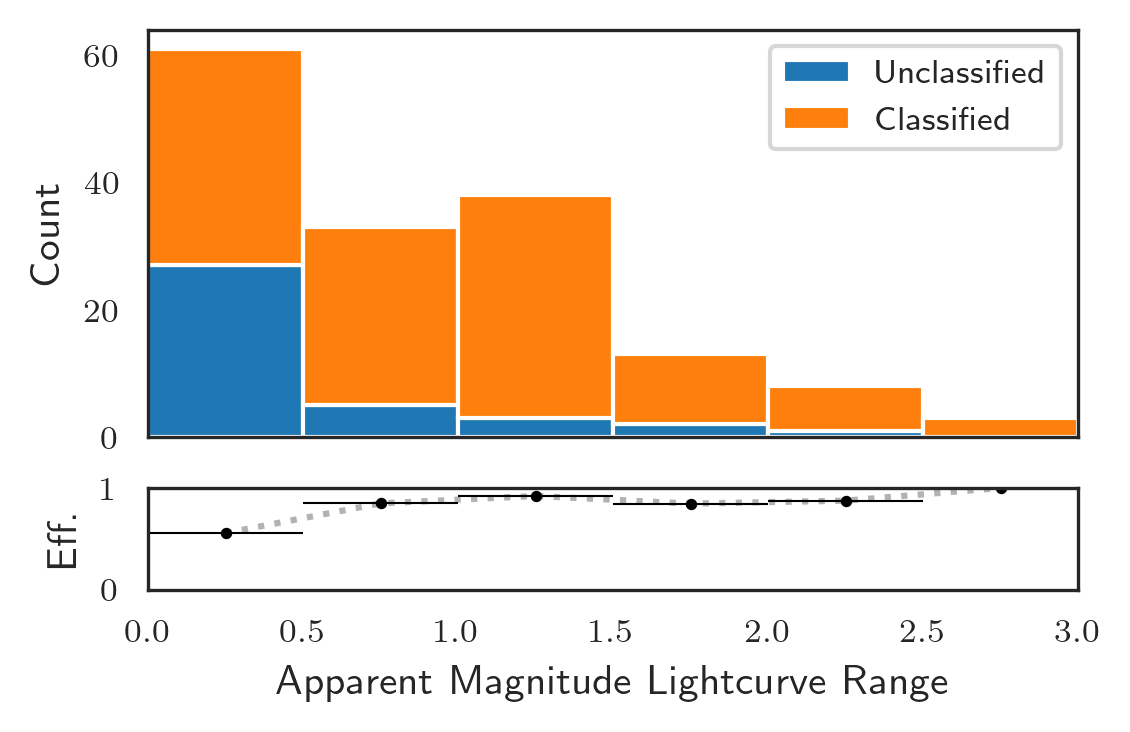

In [14]:
mask = np.array([x in ["Unclassified", "Unknown"] for x in candidates["class"]])


bins = np.linspace(0.0, 3.0, 7)
mids = 0.5*(bins[:-1] + bins[1:])

plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax1 = plt.subplot2grid((4, 1), (0, 0), colspan=3, rowspan=3)

n, _, _ = plt.hist(
    [list(candidates["max_range"][mask]), list(candidates["max_range"][~mask])],
    label=["Unclassified", "Classified"],
    bins=bins,
    stacked=True
)

ax1.set_ylabel("Count")

plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), colspan=3, rowspan=1, sharex=ax1)

fs = (n[1] - n[0])/(n[1])
fs[np.isnan(fs)] = 1.

ax2.scatter(mids, fs, color="k", s=3.)
ax2.errorbar(mids, fs, color="k", linestyle=" ", xerr=0.25, elinewidth=0.5)
ax2.plot(mids, fs, alpha=0.3, color="k", linestyle=":")
ax2.set_ylim(0.0, 1.0)
ax2.set_ylabel("Eff.")

xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlim(bins[0], bins[-1])
plt.subplots_adjust(hspace=0.5)

ax2.set_xlabel("Apparent Magnitude Lightcurve Range", fontsize=big_fontsize)

filename = "completeness_range.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

Text(0.5, 0, 'Peak Apparent Magnitude')

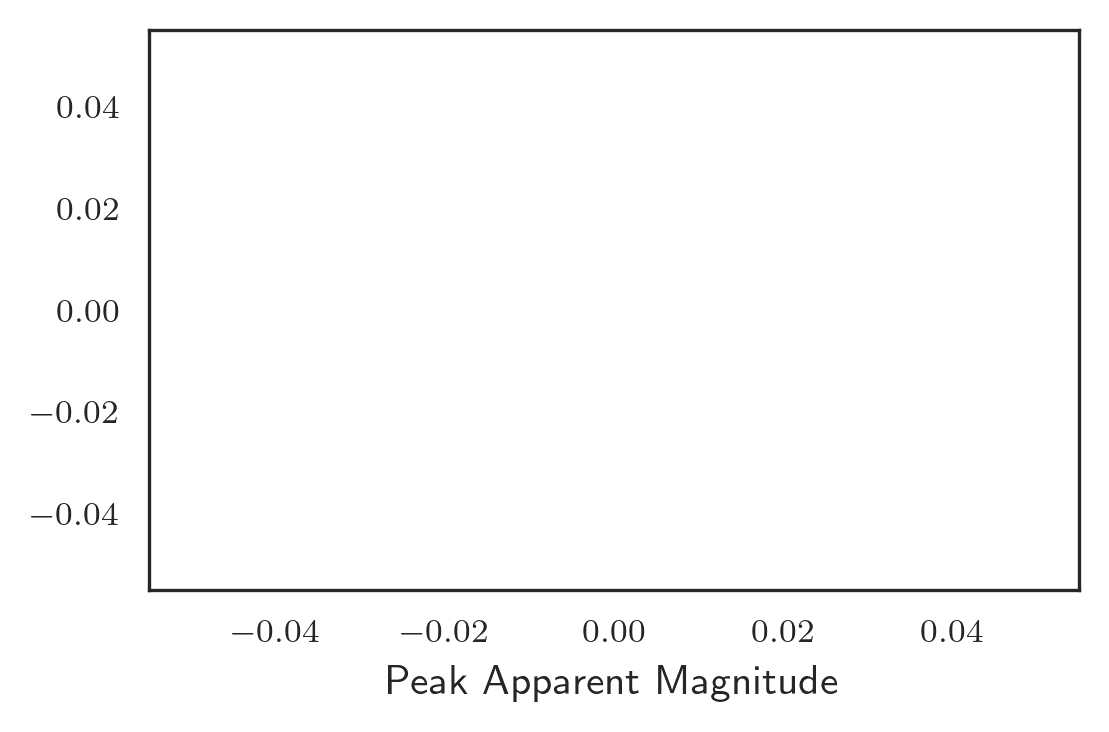

In [15]:
mask = candidates["class"] == "Unknown"
unk = candidates[mask]

plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax1 = plt.subplot(111)
plt.scatter(unk["max_brightness"], range(np.sum(mask))
)
plt.xlabel("Peak Apparent Magnitude", fontsize=big_fontsize)

# output_path = os.path.join(output_folder, filename)
# plt.savefig(f"plots/{filename}")
# plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

In [16]:
mask = ["AGN" in x for x in candidates["class"]]
agn = candidates[mask]

text=""

for _, c in candidates.iterrows():
    if c["class"] in ["AGN Flare", "Unknown", "Unclassified"]:
        text += f"{c['Name']}\n"
    
print(text)


ZTF19abahiwr
ZTF19abahiya
ZTF19abahlep
ZTF18acekfly
ZTF19abassjx
ZTF19abexshr
ZTF19abwaurq
ZTF19acbpqfn
ZTF19acbpqui
ZTF19acbxahc
ZTF19acbxanz
ZTF19acbxaqj
ZTF19acbxauk
ZTF19acbxbjq
ZTF19accnqlc
ZTF18aaidhnq
ZTF18aceykyg
ZTF18adgvgdk
ZTF19aapsgtb
ZTF19acmwlds
ZTF20aaeuufe
ZTF20aaevfth
ZTF20aaevfwa
ZTF20aagwcuq
ZTF20aagwcuu
ZTF20aagwcuv
ZTF20aagxfta
ZTF19acxopgh
ZTF20aaglixd
ZTF18aamjqes
ZTF18aavecmo
ZTF18abrwqpr
ZTF20aaxcdok
ZTF20abdnowp
ZTF20abdnoxm
ZTF20abdnoyu
ZTF20abdnpae
ZTF20abdnpbu
ZTF20abdrnlg
ZTF18acccxxf
ZTF18adbbnry
ZTF20acaapwn
ZTF20acaapwo
ZTF20acmxnpa
ZTF18abxrpgu
ZTF20acuqdeu
ZTF20acxbkpz
ZTF18abwhosy
ZTF19aaapmca
ZTF19aasfvqm
ZTF21aajxjrv
ZTF21aajxjry
ZTF20acinvxv
ZTF18abteipt



# Neutrino statistics

21 V1 alerts, 59 V2 alerts


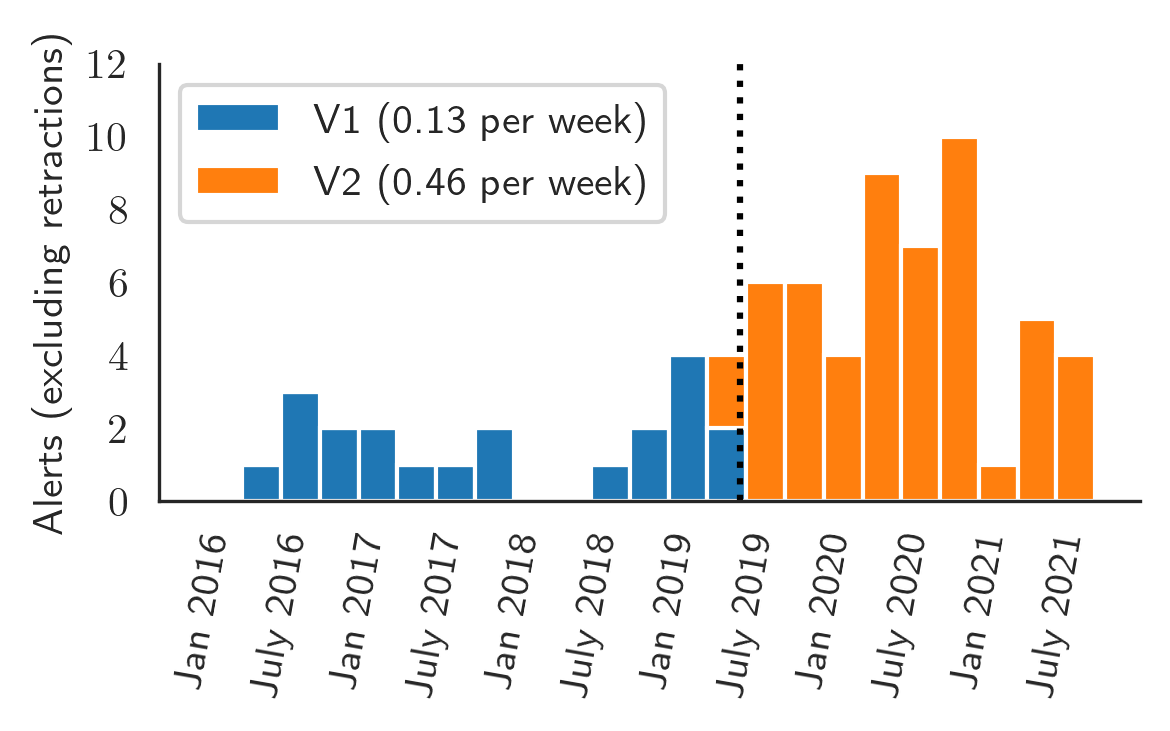

In [17]:
dates = [Time(f"20{x[2:4]}-{x[4:6]}-{x[6:8]}T00:00:01") for x in joint["Event"]]

plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax1 = plt.subplot(111)

mjds = []
labs = []
bins = []

for year in range(2016, 2022):
    for k, month in enumerate([1, 4, 7, 10]):
        
        t = Time(f"{year}-{month}-01T00:00:00.01", format='isot', scale='utc').mjd
        
        bins.append(t)
        
        if (k - 1) % 2 > 0:
                    
            mjds.append(t)
            labs.append(["Jan", "July"][int(k/2)] + f" {year}")
            
t_0 = Time(f"2016-04-01T00:00:00.01", format='isot', scale='utc').mjd 
            
v1_t = Time(f"2019-06-17T00:00:00.01", format='isot', scale='utc').mjd

t_now = Time.now().mjd

alerts_v1 = [x.mjd for i, x in enumerate(dates) if np.logical_and(x.mjd < v1_t, not np.isnan(joint.iloc[i]["Dec"]))]

alerts_v2 = [x.mjd for i, x in enumerate(dates) if np.logical_and(
    x.mjd > v1_t, not np.isnan(joint.iloc[i]["Dec"]))]

print(f'{len(alerts_v1)} V1 alerts, {len(alerts_v2)} V2 alerts')

mod = 7.

v1_rate = mod * float(len(alerts_v1))/(v1_t - t_0)
v2_rate = mod * float(len(alerts_v2))/(t_now - v1_t)

labels = []

for (name, rate) in [("V1", v1_rate), ("V2", v2_rate)]:
    labels.append(f'{name} ({rate:.2f} per week)')
    
plt.xticks(mjds, labs, rotation=80)
plt.locator_params(axis="y", nbins=6)
plt.hist([alerts_v1, alerts_v2], bins=bins, stacked=True, label=labels)

plt.axvline(v1_t, linestyle=":", color="k")

plt.tick_params(axis='both', which='major', labelsize=big_fontsize)
plt.legend(fontsize=big_fontsize, loc="upper left")

plt.ylabel("Alerts (excluding retractions)", fontsize=big_fontsize)

sns.despine()

plt.ylim(0., 12.)
plt.tight_layout()

filename = "alert_hist.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

9.34
21 V1 alerts, 59 V2 alerts


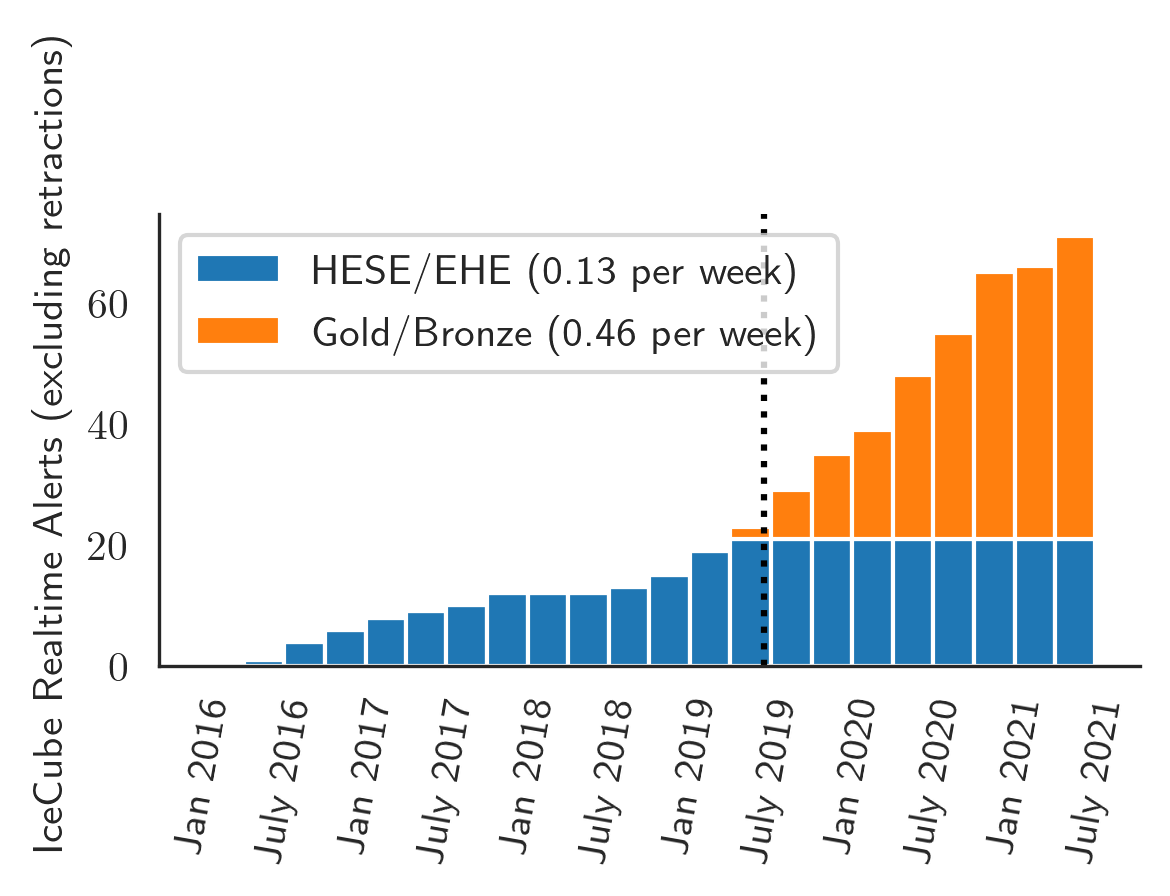

In [18]:
plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax1 = plt.subplot(111)

dates = [Time(f"20{x[2:4]}-{x[4:6]}-{x[6:8]}T00:00:01") for x in joint["Event"]]

mjds = []
labs = []
bins = []

for year in range(2016, 2022):
    for k, month in enumerate([1, 4, 7, 10]):
        
        t = Time(f"{year}-{month}-01T00:00:00.01", format='isot', scale='utc').mjd
        
        bins.append(t)
        
        if (k - 1) % 2 > 0:
                    
            mjds.append(t)
            labs.append(["Jan", "July"][int(k/2)] + f" {year}")
            
t_0 = Time(f"2016-04-01T00:00:00.01", format='isot', scale='utc').mjd 
            
v1_t = Time(f"2019-06-17T00:00:00.01", format='isot', scale='utc').mjd

t_now = Time.now().mjd

print(joint.iloc[0]["Dec"])

alerts_v1 = [x.mjd for i, x in enumerate(dates) if np.logical_and(x.mjd < v1_t, not np.isnan(joint.iloc[i]["Dec"]))]

alerts_v2 = [x.mjd for i, x in enumerate(dates) if np.logical_and(
    x.mjd > v1_t, not np.isnan(joint.iloc[i]["Dec"]))]

print(f'{len(alerts_v1)} V1 alerts, {len(alerts_v2)} V2 alerts')

mod = 7.

v1_rate = mod * float(len(alerts_v1))/(v1_t - t_0)
v2_rate = mod * float(len(alerts_v2))/(t_now - v1_t)

labels = []

for (name, rate) in [("HESE/EHE", v1_rate), ("Gold/Bronze", v2_rate)]:
    labels.append(f'{name} ({rate:.2f} per week)')
    
plt.xticks(mjds, labs, rotation=80)
plt.locator_params(axis="y", nbins=6)
plt.hist([alerts_v1, alerts_v2], bins=bins[:-1], stacked=True, label=labels, cumulative=True)

plt.axvline(v1_t, linestyle=":", color="k")

plt.tick_params(axis='both', which='major', labelsize=big_fontsize)
plt.legend(fontsize=big_fontsize, loc="upper left")

sns.despine()

# plt.ylim(0., 12.)
plt.ylabel("IceCube Realtime Alerts (excluding retractions)", fontsize=big_fontsize)
plt.tight_layout()

filename = "alert_cdf.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

1 V1 alerts, 23 V2 alerts


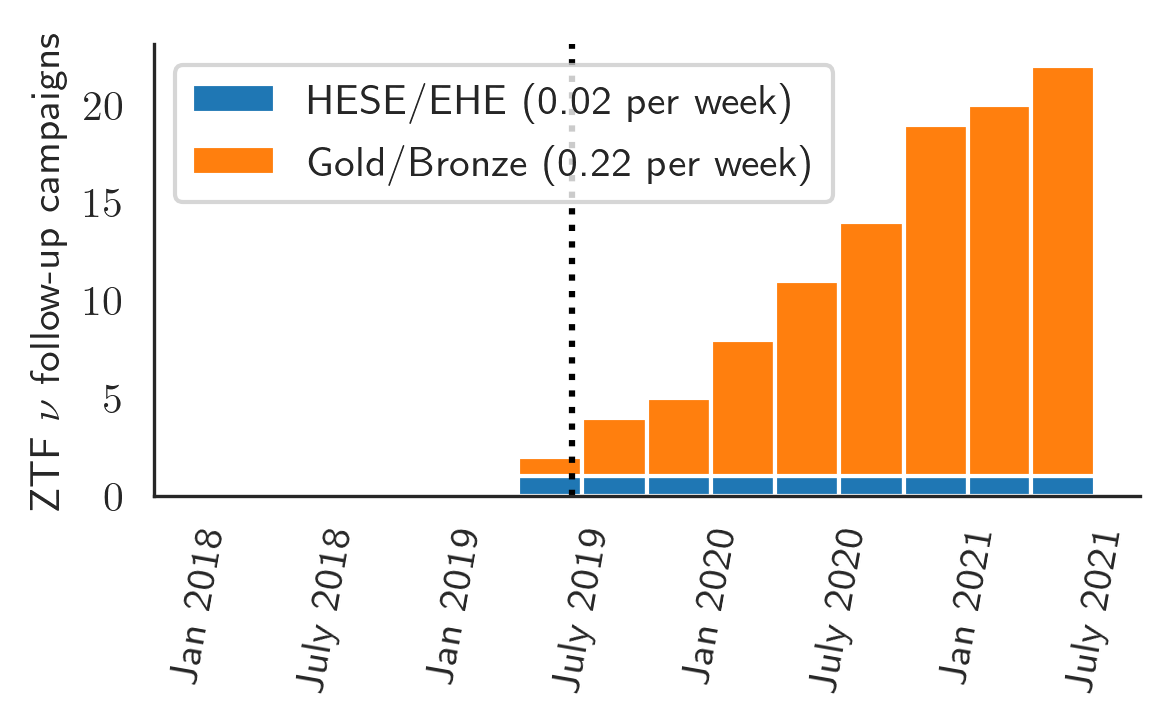

In [19]:
plt.figure(figsize=(base_width, base_height), dpi=dpi)
ax1 = plt.subplot(111)

dates = [Time(f"20{x[2:4]}-{x[4:6]}-{x[6:8]}T00:00:01") for x in obs["Event"]]

mjds = []
labs = []
bins = []

for year in range(2018, 2022):
    for k, month in enumerate([1, 4, 7, 10]):
        
        t = Time(f"{year}-{month}-01T00:00:00.01", format='isot', scale='utc').mjd
        
        bins.append(t)
        
        if (k - 1) % 2 > 0:
                    
            mjds.append(t)
            labs.append(["Jan", "July"][int(k/2)] + f" {year}")
            
t_0 = Time(f"2018-04-01T00:00:00.01", format='isot', scale='utc').mjd 
            
v1_t = Time(f"2019-06-17T00:00:00.01", format='isot', scale='utc').mjd

t_now = Time(f"2021-07-01T00:00:00.01", format='isot', scale='utc').mjd

t_bran_cut = Time(f"2020-02-01T00:00:00.01", format='isot', scale='utc').mjd

alerts_v1 = [x.mjd for x in dates if x.mjd < v1_t]

alerts_v2 = [x.mjd for x in dates if x.mjd > v1_t]

print(f'{len(alerts_v1)} V1 alerts, {len(alerts_v2)} V2 alerts')

mod = 7.

v1_rate = mod * float(len(alerts_v1))/(v1_t - t_0)
v2_rate = mod * float(len(alerts_v2))/(t_now - v1_t)

labels = []

for (name, rate) in [("HESE/EHE", v1_rate), ("Gold/Bronze", v2_rate)]:
    labels.append(f'{name} ({rate:.2f} per week)')
    
plt.xticks(mjds, labs, rotation=80)
plt.locator_params(axis="y", nbins=6)
plt.hist([alerts_v1, alerts_v2], bins=bins[:-1], stacked=True, label=labels, cumulative=True)

plt.axvline(v1_t, linestyle=":", color="k")
# plt.axvline(t_bran_cut, linestyle="--", color="k")

plt.tick_params(axis='both', which='major', labelsize=big_fontsize)
plt.legend(fontsize=big_fontsize, loc="upper left")

sns.despine()

# plt.ylim(0., 12.)
plt.ylabel(r"ZTF $\nu$ follow-up campaigns", fontsize=big_fontsize)
plt.tight_layout()

filename = "ztf_cdf.pdf"

output_path = os.path.join(output_folder, filename)
plt.savefig(f"plots/{filename}")
plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

In [20]:
classes = list(set(joint["Class"]))

for x in classes:
    n_obs = np.sum(obs["Class"] == x)
    n_tot = np.sum(np.logical_and(joint["Class"]==x, ~np.isnan(joint["Dec"])))
    n_retracted = np.sum(np.logical_and(joint["Class"]==x, np.isnan(joint["Dec"])))
    print(f'For {x}: we have observed ({int(n_obs)}/{int(n_tot)}), or {100.*n_obs/n_tot:.1f}\%')
    print(f"There were an extra {n_retracted} events that were retracted.")
    

For GOLD: we have observed (15/21), or 71.4\%
There were an extra 3 events that were retracted.
For EXTRA: we have observed (1/2), or 50.0\%
There were an extra 0 events that were retracted.
For HESE+EHE: we have observed (0/1), or 0.0\%
There were an extra 0 events that were retracted.
For BRONZE: we have observed (7/36), or 19.4\%
There were an extra 3 events that were retracted.
For HESE: we have observed (0/12), or 0.0\%
There were an extra 5 events that were retracted.
For EHE: we have observed (1/8), or 12.5\%
There were an extra 0 events that were retracted.


In [21]:
f_det = 0.4

# sum plus assume 50% for extra
n_astro = np.sum(obs["Signalness"]) + 0.5

# n_exp 90% lower bound
n_det = 0.25

print(f'We have observed {n_astro:.2f} astrophysical neutrinos')

print(f'Two TDEs were detected, corresponding to a 90% lower bound of {n_det}')

frac_det = n_det/n_astro

print(f'This implies a minimum fraction of {100.*frac_det:.2f}% neutrinos from ZTF-detected TDEs')

frac_tot = frac_det/f_det

print(f'This implies a minimum fraction of {100.*frac_tot:.2f}% neutrinos from all TDEs')

We have observed 11.70 astrophysical neutrinos
Two TDEs were detected, corresponding to a 90% lower bound of 0.25
This implies a minimum fraction of 2.14% neutrinos from ZTF-detected TDEs
This implies a minimum fraction of 5.34% neutrinos from all TDEs


In [22]:
7800./6562.8 - 1.

0.1885170963613092

In [23]:
print(f'We have observed {tot_area:.2f} sq. deg.')

We have observed 154.33 sq. deg.


In [24]:
from scipy.stats import norm, poisson

tde_density = 1.2 * 10. ** -4.

ztf_obs = tot_area

n_exp = tde_density * tot_area

def nexp_convert(nexp, n_det=2):
    
    cdf = poisson(nexp).cdf(n_det-1)

    p_val = 1. - cdf

    sigma = norm.ppf(cdf)
    
    return p_val, sigma

print(nexp_convert(n_exp, n_det=1))

print(nexp_convert(n_exp))

(0.01834890818259205, 2.0891100669396336)
(0.00016938039312475173, 3.5837002822116273)


In [25]:
sigma = norm.ppf(1.-3.*10.**-12.)
print(sigma)

6.879647382639817
